# Transformer From Scratch

## References

* https://arxiv.org/abs/1706.03762 (Attention is all you need)
* https://www.youtube.com/watch?v=eMlx5fFNoYc (3Blue1Brown)
* https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html (Sebastian Raschka)
* https://www.youtube.com/watch?v=kCc8FmEb1nY (Andrej Karapathy)
* https://arxiv.org/pdf/2005.14165 (Language Models are Few-Shot Learners)
* https://arxiv.org/abs/1512.03385 (Deep Residual Learning for Image Recognition)
* https://arxiv.org/pdf/1607.06450 (Layer Norm)


## Architecture

![transformers](./images/Arch_Transformers.png)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

torch.manual_seed(1)


## Embedding

* Creating dummy encodings here to replicate the effect of any embedding model.
* We can pick any pretrained embedding model (word2vec, bert etc.) to get word vectors.
* Idea is to get vector representation of each word with comparable information in a mathematical plane.



### Tokenization

Sentence - `I am new to NLP with Deep Learning.`

Convinient Lie - `I|am|new|to|NLP|with|Deep|Learning|.` (We'll be using this for now. Easy to interpret)

Actual Truth - `I |am |new to| NLP |with |Deep |Learn|ing.` (this is done using BytePairEncoding)

### Byte Pair Encoding

* https://huggingface.co/learn/nlp-course/en/chapter6/5

1. separate each character, add everything in vocab
2. create character pairs and find frequency of each pair
3. add most frequent pair to the vocab
4. repeat step 2 and 3 till the point there's no more frequent pair left or desired vocab size is reached.

* https://github.com/nishantbaheti/tokkit

Running the algorithm till the point we get no additional pairs to add to a vocab list.

### Legacy Tokenization

In [2]:
paragraph = """I am new to NLP with deep learning. I like Deep Learning and I like NLP. I am trying to combine it."""


bow = paragraph.lower().replace(".", "").split(" ")

vocab = set(bow)

In [3]:
tokenizer = {val: idx for idx, val in enumerate(vocab)}

In [4]:
def sentence_separator(sentence):
    return sentence.lower().replace(".", "").split(" ")


def get_tokens(sentence):
    sentence_sep = sentence_separator(sentence)
    tokens = torch.Tensor([tokenizer[i] for i in sentence_sep]).type(torch.int32)
    return tokens


def get_embedding(tokens, dim=30):
    embed = torch.nn.Embedding(len(vocab), dim)

    # detach will make it non learnable parameter and in case of transformers 
    # it is not needed to have learnable embeddings
    # if we are using pretrained models
    embedded_sentence = embed(tokens).detach()
    return embedded_sentence

In [5]:
sentence = "I like NLP"
tokens = get_tokens(sentence)
tokens

tensor([0, 4, 3], dtype=torch.int32)

In [6]:
X = get_embedding(tokens, dim=10)

In [7]:
X

tensor([[-1.5256, -0.7502, -0.6540, -1.6095, -0.1002, -0.6092, -0.9798, -1.6091,
         -0.7121,  0.3037],
        [-0.1110,  0.2927, -0.1578, -0.0288,  2.3571, -1.0373,  1.5748, -0.6298,
         -0.9274,  0.5451],
        [-0.7981, -0.1316,  1.8793, -0.0721,  0.1578, -0.7735,  0.1991,  0.0457,
          0.1530, -0.4757]])

In [8]:
X.shape

torch.Size([3, 10])

This shape is currently (T, M), but what we would actually need is (B, T, M) where B = Batch, as part of training cycle we'll have to train it in a batch

In [9]:
X.unsqueeze(0).shape

torch.Size([1, 3, 10])

## Positional Encoding

![positional encoding](images/Arch_PositionalEncoding.png)

* As attention is mechanism is desined to work in parallel (as opposed to older Seq2Seq Model to overcome the performance issue) to provide the sense of sequence in input tokens is necessary.
* Positional Encoding provides each token a positional aware representation in a sequence

> In a sentence **This is going to happen anyways** . the relationship has to be represented that **going** is two steps after **This** and **to** is one steps after **going**, this positional awareness/ markers of the position in the sentence has to be infused somehow in the input embeddings of set of tokens in sequence.

* Each position has a UNIQUE encoding
* Compatible with Attention Mechanism
* Due to sine and cosine - it is scale invariant

\begin{align*}
PE(pos, 2i) &= \sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) \\\\
PE(pos, 2i + 1) &= \cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) \\\\
\text{where, }
pos &= \text{Position of token in sequence} \\
i &= \text{index of dimension} \\
d_{model} &= \text{dimension of model\ embdeding size of the model} \\
\end{align*}

* Single value of $i \in [0, d_{model})$ map both sine and cosine function
* values will reside in -1 and 1
* 10000 is a scaling value
* Why sine & cosine ? 
    * Phase difference encoding uniqueness
    * Linearly independent
    * due to sine and cosine properties, calculatable that token 5 is closer to token 6 than token 10 without maintaining a sequence,

In [10]:
def positional_encoding(n_tokens, d_model, scale=10_000):
    """
    * Rows - Positions (sentence length, number of tokens in input sentence)
    * Columns - Dimensions (Dimensions of embedding or models)
    """
    p = torch.zeros((n_tokens, d_model))
    positions = torch.arange(n_tokens)

    # for loop approach - just need to run it for half of the dimensions as 
    for i in range(int(d_model / 2)):
        denominator = 1 / math.pow(scale, (2 * i) / d_model)

        p[positions, 2 * i] = torch.sin(positions * denominator)
        p[positions, (2 * i) + 1] = torch.cos(positions * denominator)
    return p

positional_encoding(5, 5)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [ 0.8415,  0.5403,  0.0251,  0.9997,  0.0000],
        [ 0.9093, -0.4161,  0.0502,  0.9987,  0.0000],
        [ 0.1411, -0.9900,  0.0753,  0.9972,  0.0000],
        [-0.7568, -0.6536,  0.1003,  0.9950,  0.0000]])

As for loop is not optimized and pytorch tensor does matrix operations for efficiently so below is the optimized approach

In [11]:
def positional_encoding_opt(n_tokens, d_model, scale=10_000):
    """
    * Rows - Positions (sentence length, number of tokens in input sentence)
    * Columns - Dimensions (Dimensions of embedding or models)
    """
    p = torch.zeros((n_tokens, d_model))
    positions = torch.arange(n_tokens).unsqueeze(1)
    denominator = 1 / torch.pow(scale, torch.arange(0, d_model, 2).unsqueeze(0) / d_model)

    if d_model % 2 == 0:
        end_idx = denominator.shape[1]
    else:
        end_idx = denominator.shape[1] - 1
    
    # for even indexes
    p[:, 0::2] = torch.sin(positions * denominator)

    # for odd indexes
    p[:, 1::2] = torch.cos(positions * denominator[:, :end_idx])
    return p


positional_encoding_opt(5, 5)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  2.5116e-02,  9.9968e-01,  6.3096e-04],
        [ 9.0930e-01, -4.1615e-01,  5.0217e-02,  9.9874e-01,  1.2619e-03],
        [ 1.4112e-01, -9.8999e-01,  7.5285e-02,  9.9716e-01,  1.8929e-03],
        [-7.5680e-01, -6.5364e-01,  1.0031e-01,  9.9496e-01,  2.5238e-03]])

In [12]:
pd.DataFrame(
    positional_encoding_opt(4, 4, 100),
    columns=[f"dim {i}" for i in range(4)],
    index=[f"pos {i}" for i in range(4)],
)

,dim 0,dim 1,dim 2,dim 3
pos 0,0.000000,1.000000,0.000000,1.000000
pos 1,0.841471,0.540302,0.099833,0.995004
pos 2,0.909297,-0.416147,0.198669,0.980067
pos 3,0.141120,-0.989992,0.295520,0.955337


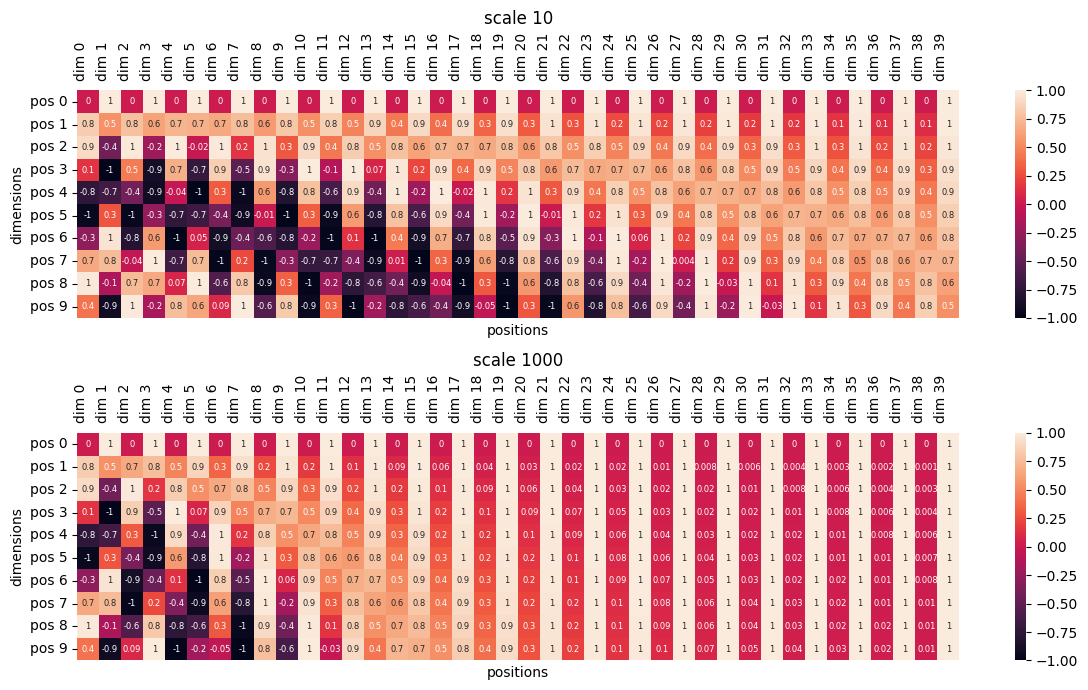

In [13]:
d_model = 40 # M
n_tokens = 10 # T


fig, ax = plt.subplots(2, 1, figsize=(12, 7))
pos_enc = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=10)
sns.heatmap(
    pd.DataFrame(
        pos_enc,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ),
    vmin=-1,
    vmax=1,
    ax=ax[0],
    annot=True,
    fmt=".1g",
    annot_kws={"fontsize": 6}
)
ax[0].set_title("scale 10")
ax[0].set_ylabel("dimensions")
ax[0].set_xlabel("positions")
ax[0].tick_params(labelbottom = False, bottom=False, top = False, labeltop=True)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')

pos_enc = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=1000)
sns.heatmap(
    pd.DataFrame(
        pos_enc,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ),
    vmin=-1,
    vmax=1,
    ax=ax[1],
    annot=True,
    fmt=".1g",
    annot_kws={"fontsize":6}
)
ax[1].set_title("scale 1000")
ax[1].set_ylabel("dimensions")
ax[1].set_xlabel("positions")
ax[1].tick_params(labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')

plt.tight_layout()
plt.show()

Here `pos` is token position and `dim` embedding dimension, It is like we would want to map each token's each dimesion.

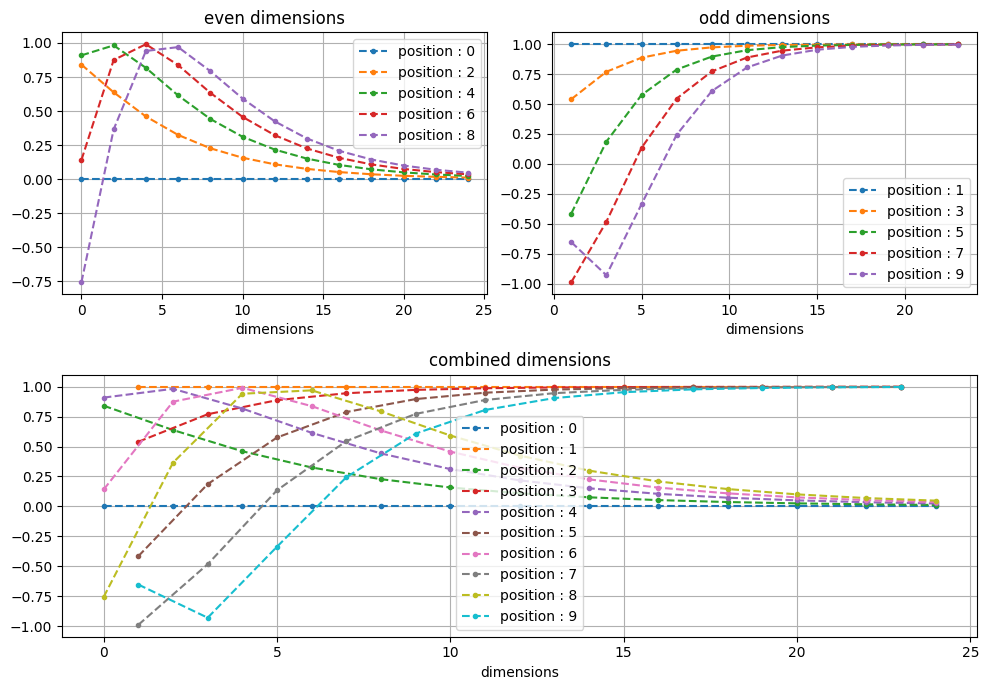

In [14]:
d_model = 25
n_tokens = 10
pos_enc = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=100)

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3, 4))

# individual
for i in range(int(n_tokens/2)):
    # For even position
    ax1.plot(np.arange(0, d_model, 2), pos_enc[i, 0::2], ".--", label=f"position : {2 * i}")

    # For odd position
    ax2.plot(
        np.arange(1, d_model, 2), pos_enc[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )
ax1.legend()
ax1.grid()
ax1.set_title("even dimensions")
ax1.set_xlabel("dimensions")

ax2.legend()
ax2.grid()
ax2.set_title("odd dimensions")
ax2.set_xlabel("dimensions")


# combined
for i in range(int(n_tokens/2)):
    # For even position
    ax3.plot(np.arange(0, d_model, 2), pos_enc[i, 0::2], ".--", label=f"position : {2 * i}")
    
    # For odd position
    ax3.plot(
        np.arange(1, d_model, 2), pos_enc[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )

ax3.legend(loc="best")
ax3.grid()
ax3.set_title("combined dimensions")
ax3.set_xlabel("dimensions")

plt.tight_layout()
plt.show()

Similarity between position 0 vs 1 and 0 vs 5

In [15]:
(
    torch.cosine_similarity(pos_enc[0].view(1, -1), pos_enc[1].view(1, -1)), 
    torch.cosine_similarity(pos_enc[0].view(1, -1), pos_enc[5].view(1, -1)),
)

(tensor([0.9245]), tensor([0.4458]))

In [16]:
(
    torch.cosine_similarity(pos_enc[1].view(1, -1), pos_enc[2].view(1, -1)), 
    torch.cosine_similarity(pos_enc[5].view(1, -1), pos_enc[2].view(1, -1)),
)

(tensor([0.9245]), tensor([0.5639]))

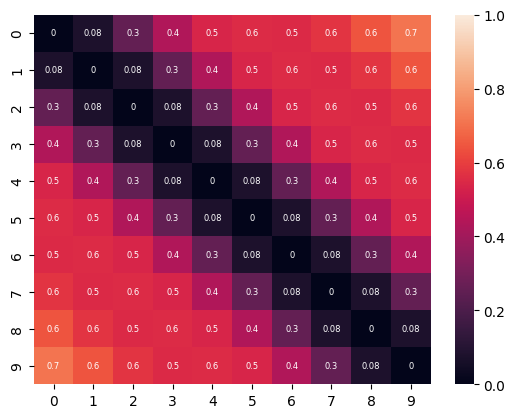

In [17]:
from sklearn.metrics.pairwise import cosine_distances

sns.heatmap(
    pd.DataFrame(
        cosine_distances(pos_enc),
    ),
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".1g",
    annot_kws={"fontsize":6}
);

* Closer positions have less cosine distance makes it position aware, even it is in parallel

### Token Embedding + Positional Encoding

In [18]:
sentence = "I am new to NLP with deep learning."
tokens = get_tokens(sentence)

In [19]:
n_tokens = len(tokens) # T
d_model = 10 # M

pos_enc = positional_encoding_opt(n_tokens=n_tokens, d_model=d_model, scale=100)
df = pd.DataFrame(
    pos_enc,
    columns=[f"dim {i}" for i in range(pos_enc.shape[1])],
    index=[f"pos {i}" for i in range(pos_enc.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
pos 1,am,10,0.841471,0.540302,0.387674,0.921796,0.157827,0.987467,0.063054,0.998010,0.025116,0.999685
pos 2,new,1,0.909297,-0.416147,0.714713,0.699417,0.311697,0.950181,0.125857,0.992048,0.050217,0.998738
pos 3,to,11,0.141120,-0.989992,0.929966,0.367644,0.457755,0.889079,0.188159,0.982139,0.075285,0.997162
pos 4,nlp,3,-0.756802,-0.653644,0.999766,-0.021631,0.592338,0.805690,0.249712,0.968320,0.100306,0.994957
pos 5,with,9,-0.958924,0.283662,0.913195,-0.407523,0.712073,0.702105,0.310272,0.950648,0.125264,0.992123
pos 6,deep,2,-0.279415,0.960170,0.683794,-0.729675,0.813960,0.580922,0.369596,0.929192,0.150143,0.988664
pos 7,learning,12,0.656987,0.753902,0.347443,-0.937701,0.895443,0.445176,0.427450,0.904039,0.174927,0.984581


In [20]:
embeddings = get_embedding(tokens, dim=d_model)
embeddings.shape

torch.Size([8, 10])

In [21]:
df = pd.DataFrame(
    embeddings,
    columns=[f"dim {i}" for i in range(embeddings.shape[1])],
    index=[f"pos {i}" for i in range(embeddings.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,0,1.511267,0.641871,0.472964,-0.428590,0.551371,-1.547371,0.757480,-0.406761,0.269241,1.324768
pos 1,am,10,-0.229668,0.001331,0.144404,0.777168,-0.572309,1.009717,-0.105649,-1.179696,-0.090780,0.563114
pos 2,new,1,1.746019,1.854969,-0.706369,2.557086,0.770532,-1.073910,-0.839958,-0.420018,-0.624036,-0.977296
pos 3,to,11,-0.587336,-2.061921,0.167477,0.751421,-0.197000,-0.033396,0.719292,1.064415,-0.833572,-1.192856
pos 4,nlp,3,-0.389119,-0.079600,0.526932,1.619253,-0.963976,0.141520,-0.163661,-0.358223,-0.059444,-2.491939
pos 5,with,9,1.724086,-2.364765,-0.929491,0.293625,1.660414,0.271740,1.465708,-0.556474,-0.744841,-0.202157
pos 6,deep,2,0.874843,0.987281,0.250468,-0.793033,1.205234,-1.815591,-0.403462,-0.959145,-0.005208,-0.078863
pos 7,learning,12,-2.306489,0.603657,0.315085,1.142252,0.305506,-0.578882,0.564354,-0.877328,-0.269253,1.311956


Positional Embedding

In [22]:
pos_enc.shape, embeddings.shape

(torch.Size([8, 10]), torch.Size([8, 10]))

In [23]:
pos_emb = pos_enc + embeddings
pos_emb

df = pd.DataFrame(
    pos_emb,
    columns=[f"dim {i}" for i in range(pos_emb.shape[1])],
    index=[f"pos {i}" for i in range(pos_emb.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,0,1.511267,1.641871,0.472964,0.571410,0.551371,-0.547371,0.757480,0.593239,0.269241,2.324768
pos 1,am,10,0.611803,0.541634,0.532078,1.698965,-0.414482,1.997184,-0.042596,-0.181686,-0.065663,1.562799
pos 2,new,1,2.655317,1.438822,0.008344,3.256504,1.082229,-0.123728,-0.714101,0.572031,-0.573820,0.021442
pos 3,to,11,-0.446216,-3.051913,1.097444,1.119065,0.260754,0.855682,0.907450,2.046553,-0.758287,-0.195694
pos 4,nlp,3,-1.145922,-0.733244,1.526698,1.597623,-0.371639,0.947210,0.086051,0.610098,0.040863,-1.496983
pos 5,with,9,0.765162,-2.081103,-0.016296,-0.113897,2.372487,0.973845,1.775979,0.394174,-0.619576,0.789966
pos 6,deep,2,0.595427,1.947452,0.934262,-1.522708,2.019193,-1.234669,-0.033865,-0.029953,0.144936,0.909801
pos 7,learning,12,-1.649502,1.357559,0.662528,0.204551,1.200949,-0.133705,0.991804,0.026711,-0.094325,2.296538


In [24]:
pos_emb.shape

torch.Size([8, 10])

But in practice the input will be Embedding (B, T, M) + Positional Encoding (1, T, M) = (B, T, M)

In [25]:
(pos_enc + embeddings.unsqueeze(0)).shape

torch.Size([1, 8, 10])

## Scaled Dot-Product Attention (SingleHead)



![scaled-dot-product-attention](./images/Arch_ScaledDotProductAttention.png) 
![multi-head-attention](./images/Arch_MultiHeadAttention.png)


* It is a communication mechanism (Message Passing for refernce in Graph Theory), where each word passes information/ communicates with other word with some weight.(weighted average/aggregation is passed through the next node from all surrounding nodes and iteratively all the information is aggregates to all the nodes)
* It can be understood as a contextual aggregation and a mechanism to understand each word's importance in given context

\begin{align*}
\text{Attention}(Q, K, V) &= \text{softmax}\big( \frac{Q K^T}{\sqrt{d_k}} \big)V \\ \\
Q &= W_Q.X  & q_i &= W_Q x_i \text{ where } i \in [1, T] \\
K &= W_K.X  & k_i &= W_K x_i \text{ where } i \in [1, T] \\ 
V &= W_V.X  & v_i &= W_V x_i \text{ where } i \in [1, T] \\ \\
\end{align*}

\begin{align*}
\text{where } & \\ 
T &= \text{Number of tokens in the sentence} \\
W_Q, W_K, W_V &= \text{Projection or Learning parameters/weights for query, keys and value vectors} \\
X, x_i &= \text{Input Embedding for token in a sentence } \\ \\
\text{Where Projection Parameters Represent -} & \\
Q &= \text{What am I looking for ? (What is asked)} \\
K &= \text{What do I have ? (What is given)} \\
V &= \text{What will I get ? (What is important) } \\
\end{align*}

* Lets take an example of 2 sentences 
    * I want this to be a fair game
    * I want to go to a fair

* In these sentences word `fair` has two meanings that changes with rest of the context.
* Below is the visual representation of $QK^T$ where the multiplication should result in comparably higher value while joining(multiplying) the query and keys vectors (each token gets mulitplied by the whole query) - Information of each token is aggregated to another token, and to calculate the weights it is passed through a softmax layer.
* For example - 
    
    
    ||Query $\rightarrow$| I | want | this | to | be | a | fair | game |
    |-|-|-|-|-|-|-|-|-|-|
    |Keys $\downarrow$ | I |.|.|.|.|.|.|.|.|
    || want |.|.|.|.|.|.|.|.|
    || this |.|.|.|.|.|.|.|.| 
    || to |.|.|.|.|.|.|O|.|
    || be |.|.|.|.|.|.|O|.|
    || a |.|.|.|.|.|.|O|.|
    || fair |.|.|.|O|O|O|O|O|
    || game |.|.|.|.|.|.|O|.| 

    here it roughly represents the weights of `to`, `be`, `a`, `game` for word `fair` is higher than all the other words. This is just a representation of important information in the sentence, that passes through a position encoder to get a sense of sequence as well. Now with position and importance(affinity) it gets a lot of information.


### How attention works

> To Understand the need of attention/why attention works, we might need to think about what is the input.

* When we are asking auto regressive language model to generate next token, as input we are only providing a chunk of text.
* Due to Positional Encoding/Embedding, Model has an awareness about the positions.
* Now for if you think about the next possible word for below sentence
        
        We will next ...

* It is not grammatically correct as well it doesn't have any important information for predict next word, hence the next word can be anything from city, company to year, month.
* Now if I add certain information in the sentence 
        
        We will go to India next ...

* It is grammatically correct and now with better context we have can prediction next word with higher probability like year, month.
* Now if you reached to the same conclusion, you'd think how did your mind processed this information.
* You got a sentence, you figured out main/primary contexts/words with higher weightage( go, India) and some supporting words. Using both of these insights the next word came to you based on your knowledge of general English, that you have attained over time.



In [26]:
d_model = 30

sentence = "I like learning NLP"

tokens = get_tokens(sentence)
X = get_embedding(tokens, dim=d_model)

### Linear Transformation (Projection)

* Two schools of thought
    * As the embeddings of tokens are from a separate model/vector space. (If we are using pretrained embeddings), To integrate the embeddings in the transformers vector space we need some projection vectors that belong to this architecture.
    * We are going to need learnable parameters so that we can introduce linear transformations of embeddings, kind of augmenting the inputs in various dimensions and still getting the same results in most chances.


* $d_{key} = d_{query}$ as the final result has to be a square matrix. each token with information aggregated from each token
* $d_{value} = d_{model}$ as the result fo the attention will have the similar dimension as the input


In [27]:
d_query, d_key  = (24, 24)
d_value = d_model

W_Q = torch.rand(d_query, d_model, requires_grad=True) * 1e-1
W_K = torch.rand(d_key, d_model, requires_grad=True) * 1e-1
W_V = torch.rand(d_value, d_model, requires_grad=True) * 1e-1


In [28]:
Q = torch.matmul(X, W_Q.T)

# alternatively 
# W_Q = torch.nn.Linear(d_model, bias=False)
# Q = W_Q(X)
K = torch.matmul(X, W_K.T)
V = torch.matmul(X, W_V.T)

Q.shape, K.shape, V.shape

(torch.Size([4, 24]), torch.Size([4, 24]), torch.Size([4, 30]))

### Q . K (dot product)

* Why dot product, to understand this first we need to understand matrix multiplication (https://mlguidebook.com/en/latest/MathExploration/matrix_multiplication.html)
* Here every word will talk to each other, and the embedding dimesions are multiplied (Contextual Aggergation).


\begin{align*}
Q (T, M)
\begin{bmatrix}
q_{1,1} & q_{1,2} & \dots & q_{1,M}\\
q_{2,1} & q_{2,2} & \dots & q_{2,M}\\
& & .\\
& & .\\
q_{T,1} & q_{T,2} & \dots & q_{T,M}
\end{bmatrix} \times
K^T (M, T)
\begin{bmatrix}
k^T_{1,1} & k^T_{1,2} & \dots & k^T_{1,T}\\
k^T_{2,1} & k^T_{2,2} & \dots & k^T_{2,T}\\
& & .\\
& & .\\
k^T_{M,1} & k^T_{M,2} & \dots & k^T_{M,T}
\end{bmatrix} = \\
\\
(T, T)
\begin{bmatrix}
(q_{1,1} \times k^T_{1,1}) + (q_{1,2} \times k^T_{2,1}) + \dots + (q_{1,M} \times k^T_{M,1}) & \dots & \\
. & \\
. & \\
\end{bmatrix}
\end{align*}

* This dot product provides a (T, T) matrix where it shows relation of each token with rest of the tokens.

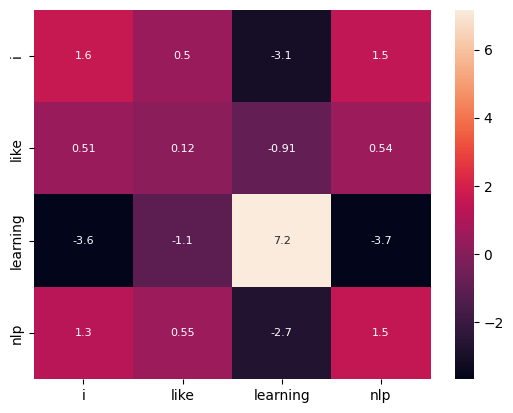

In [29]:
omega = Q @ K.T

sns.heatmap(pd.DataFrame(
    torch.round(omega, decimals=2).detach().numpy(),
    columns=sentence_separator(sentence),
    index=sentence_separator(sentence),
), annot=True, annot_kws={"size" : 8}) ;

### Softmax (Context to weight)

* from dot product we get contextual aggregation for each token, to figure out each token's weight(importance) we need a method to convert logits/matrix to weights/probability in a manner that during backpropagation the learnable parameters are trained based on backpropagation of the softmax loss.

* take below example of softmax learning

\begin{align*}
\begin{bmatrix}
w_{1,1} & w_{1,2} & \dots & w_{1,T}
\end{bmatrix} \rightarrow
softmax(\begin{bmatrix}
w_{1,1} & w_{1,2} & \dots & w_{1,T}
\end{bmatrix}) \rightarrow
\begin{bmatrix}
0 & 1 & & \dots & 0
\end{bmatrix}
\end{align*}

* At the time of backpropagation the parameters with try to reach closer to the values of true value with iterations using probabilities.

In [30]:
def softmax(x):
    if len(x.shape) == 1:
        x = x.view(1, -1)
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1).view(-1, 1)


softmax(torch.Tensor([1, 1, 1, 1])), softmax(torch.Tensor([[1, 1, 1, -1], [1, 2, 1, 4]]))

(tensor([[0.2500, 0.2500, 0.2500, 0.2500]]),
 tensor([[0.3189, 0.3189, 0.3189, 0.0432],
         [0.0403, 0.1096, 0.0403, 0.8098]]))

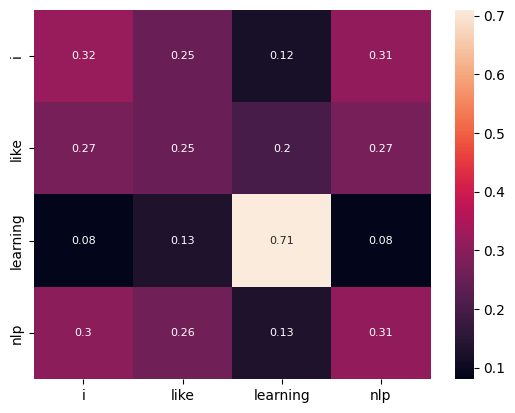

In [31]:
omega = softmax((Q @ K.T) / math.sqrt(d_key))

sns.heatmap(pd.DataFrame(
    torch.round(omega, decimals=2).detach().numpy(),
    columns=sentence_separator(sentence),
    index=sentence_separator(sentence),
), annot=True, annot_kws={"size" : 8}) ;

### Why Scaling?

* dividing by $\sqrt{d_k}$

In [32]:
Q @ K.T

tensor([[ 1.6421,  0.5003, -3.0835,  1.4681],
        [ 0.5092,  0.1187, -0.9069,  0.5416],
        [-3.6364, -1.0654,  7.1673, -3.6791],
        [ 1.2621,  0.5460, -2.6699,  1.5191]], grad_fn=<MmBackward0>)

Here the value of last cell has become very big and if this matrix is passed through softmax then it will become a one-hot vector, instead of fairly diffused vector

In [33]:
softmax(Q @ K.T)

tensor([[4.6117e-01, 1.4723e-01, 4.0886e-03, 3.8751e-01],
        [3.3872e-01, 2.2921e-01, 8.2189e-02, 3.4988e-01],
        [2.0317e-05, 2.6573e-04, 9.9969e-01, 1.9469e-05],
        [3.5698e-01, 1.7444e-01, 6.9982e-03, 4.6159e-01]],
       grad_fn=<DivBackward0>)

Now if we scale it with the value

In [34]:
(Q @ K.T)  / math.sqrt(d_key)

tensor([[ 0.3352,  0.1021, -0.6294,  0.2997],
        [ 0.1039,  0.0242, -0.1851,  0.1106],
        [-0.7423, -0.2175,  1.4630, -0.7510],
        [ 0.2576,  0.1115, -0.5450,  0.3101]], grad_fn=<DivBackward0>)

In [35]:
softmax((Q @ K.T)  / math.sqrt(d_key))

tensor([[0.3186, 0.2524, 0.1214, 0.3075],
        [0.2718, 0.2510, 0.2036, 0.2736],
        [0.0784, 0.1325, 0.7114, 0.0777],
        [0.2971, 0.2567, 0.1331, 0.3131]], grad_fn=<DivBackward0>)

* Now whole purpose of softmax is provide weights to each token and aggregate the results in value, but if there are sharp/high values in dot product resulting in one-hot encoded softmax weights then we are just taking value from one token while ignoring the other. and these extreme cases will be very frequent.

### Attention

Multiplying weights with the values

In [36]:
def attention(Q, K, V, d_key):
    omega = softmax((Q @ K.T) / np.sqrt(d_key))
    return omega @ V

In [37]:
attn_out = attention(Q, K, V, d_key)

attn_out.shape

torch.Size([4, 30])

In [38]:
df = pd.DataFrame(
    attn_out.detach().numpy(),
    columns=[f"dim {i}" for i in range(attn_out.shape[1])],
    index=sentence_separator(sentence),
)
df

,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,...,dim 20,dim 21,dim 22,dim 23,dim 24,dim 25,dim 26,dim 27,dim 28,dim 29
i,-0.112892,-0.023236,-0.151787,-0.092047,-0.055853,-0.127145,-0.068079,0.029894,-0.129760,-0.121854,...,-0.125443,-0.229218,-0.108677,-0.014848,-0.279661,-0.238828,-0.101148,-0.178327,-0.084321,0.019548
like,-0.024562,0.012532,-0.071731,-0.049711,0.006881,-0.042156,0.011113,0.075317,-0.047504,-0.054094,...,-0.049070,-0.171071,-0.042347,0.024111,-0.182212,-0.150847,-0.022608,-0.117571,-0.009506,0.061712
learning,0.475496,0.229068,0.372639,0.212255,0.340219,0.453289,0.443842,0.330805,0.441794,0.371707,...,0.413204,0.156072,0.362016,0.238389,0.384674,0.360523,0.404524,0.254254,0.401647,0.321802
nlp,-0.100842,-0.018857,-0.135670,-0.085294,-0.046696,-0.115744,-0.052055,0.038967,-0.115065,-0.112088,...,-0.116348,-0.217409,-0.095388,-0.006792,-0.259053,-0.225962,-0.087915,-0.169102,-0.068661,0.025594


### Embedding + Positional Encoding + Attention

In [39]:
d_model = 10

sentence = "I like NLP with deep learning."

tokens = get_tokens(sentence)
n_tokens = len(tokens)

embeddings = get_embedding(tokens, dim=d_model)
embeddings.shape

torch.Size([6, 10])

In [40]:
pos_enc = positional_encoding_opt(n_tokens=n_tokens, d_model=d_model, scale=100)

d_query, d_key, d_value = 10, 10, d_model

W_Q = torch.rand(d_query, d_model, requires_grad=True) * 1e-1
W_K = torch.rand(d_key, d_model, requires_grad=True) * 1e-1
W_V = torch.rand(d_value, d_model, requires_grad=True) * 1e-1

In [41]:
pos_emb = pos_enc + embeddings

In [42]:
Q = torch.matmul(pos_emb, W_Q.T)
K = torch.matmul(pos_emb, W_K.T)
V = torch.matmul(pos_emb, W_V.T)


attn_out = attention(Q, K, V, d_key)

df = pd.DataFrame(
    attn_out.detach().numpy(),
    columns=[f"dim {i}" for i in range(attn_out.shape[1])],
    index=[f"pos {i}" for i in range(attn_out.shape[0])],
)

df.insert(
    loc=0,
    column="word",
    value=sentence_separator(sentence),
)
df

,word,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,0.245278,0.229200,0.198758,0.242423,0.147853,0.227007,0.142971,0.263700,0.140218,0.163681
pos 1,like,0.245031,0.228440,0.196694,0.242378,0.145570,0.225390,0.139400,0.261076,0.140311,0.163267
pos 2,nlp,0.246045,0.234171,0.208822,0.242996,0.157139,0.235072,0.157785,0.276262,0.140354,0.165387
pos 3,with,0.243279,0.224162,0.191888,0.240293,0.140335,0.220535,0.132247,0.253662,0.139588,0.160921
pos 4,deep,0.242864,0.217258,0.182221,0.238708,0.132437,0.212683,0.120267,0.240859,0.138715,0.159016
pos 5,learning,0.246882,0.233591,0.206077,0.243901,0.155296,0.233637,0.154337,0.273562,0.140567,0.165899


## MultiHead Attention

Now the one attention can run in multiple heads parallelly to generative different transformations.


\begin{align*}
\text{Multihead}(Q, K, V) &= \text{Concat}(head_1, head_2, ... , head_h) W^o \\\\
\text{where } head_i &= \text{Attention}(QW_i^Q,KW_i^K,VW_i^V)
\end{align*}

* Once we understand how attention works, what if we get multiple attention heads (all different transformations), concat the heads and project them to a combined outcome, so that even after multiple different transformations we should be getting the similar weight ratios in most of the heads for the given input.
* This step ensures an ensemble of opinios of multiple attention heads and their learnable parameters.

![scaled-dot-product-attention](./images/Arch_ScaledDotProductAttention.png) 
![multi-head-attention](./images/Arch_MultiHeadAttention.png)

In [43]:
d_model = 100
n_heads = 3

sentence = "I like NLP with deep learning."

tokens = get_tokens(sentence)
X = get_embedding(tokens, dim=d_model).repeat(n_heads, 1, 1)

In [44]:
d_query, d_key, d_value = 28, 28, d_model

W_Q = torch.rand(n_heads, d_query, d_model, requires_grad=True) * 1e-1
W_K = torch.rand(n_heads, d_key, d_model, requires_grad=True) * 1e-1
W_V = torch.rand(n_heads, d_value, d_model, requires_grad=True) * 1e-1

In [45]:
X.shape, W_Q.shape

(torch.Size([3, 6, 100]), torch.Size([3, 28, 100]))

In [46]:
Q = torch.bmm(X, W_Q.transpose(-2, -1)) # Transposing last two dimensions (leaving heads)
K = torch.bmm(X, W_K.transpose(-2, -1))
V = torch.bmm(X, W_V.transpose(-2, -1))

Q.shape, K.shape, V.shape

(torch.Size([3, 6, 28]), torch.Size([3, 6, 28]), torch.Size([3, 6, 100]))

In [47]:
def multihead_softmax(x):
    return torch.exp(x)/ torch.exp(x).sum(dim=-1, keepdim=True)

def multihead_attention(Q, K, V, d_key):
    omega = (Q @ K.transpose(-2, -1)) / math.sqrt(d_key)
    return multihead_softmax(omega) @ V

In [48]:
attn_out = multihead_attention(Q, K, V, d_key)

attn_out.shape

torch.Size([3, 6, 100])

## Masked-MultiHead Attention (Optional)

![scaled-dot-product-attention](./images/Arch_ScaledDotProductAttention.png) 
![multi-head-attention](./images/Arch_MultiHeadAttention.png)


* mask the tokens that come in next steps (as -inf)
* so that softmax converts them to zero
* In cases of chatbot, the algorithm should not know the next word at the time of training
* so that it can predict the probability of next word based on target values and hadn't seen the value before


> This is an optional step where word prediction/generation is the use case, Hence it can be ignored for the use cases like **Language Translation**, **Sentiment Analysis** etc., where we need the whole sentence and each token to talk to each other

* Create a mask where the next word in sequence cannot communicate the previous token, mathematic before passing it to softmax next token variable in sequence are converted to -inf ($-\infty$) because $e^{-\infty} = 0$

In [49]:
math.exp(-math.inf)

0.0

In [50]:
# for example there are 5 tokens in the input sentence
M = torch.rand((5, 5))
M

tensor([[0.9250, 0.5046, 0.5574, 0.2779, 0.7089],
        [0.2986, 0.5981, 0.4517, 0.9798, 0.4209],
        [0.0336, 0.4341, 0.0508, 0.2632, 0.7929],
        [0.9536, 0.4967, 0.2589, 0.3066, 0.5826],
        [0.3141, 0.6194, 0.0822, 0.8401, 0.1696]])

In [51]:
M[torch.tril(M) == 0 ] = float("-inf")
M
# M.masked_fill(torch.tril(M) == 0, float("-inf"))

tensor([[0.9250,   -inf,   -inf,   -inf,   -inf],
        [0.2986, 0.5981,   -inf,   -inf,   -inf],
        [0.0336, 0.4341, 0.0508,   -inf,   -inf],
        [0.9536, 0.4967, 0.2589, 0.3066,   -inf],
        [0.3141, 0.6194, 0.0822, 0.8401, 0.1696]])

<Axes: >

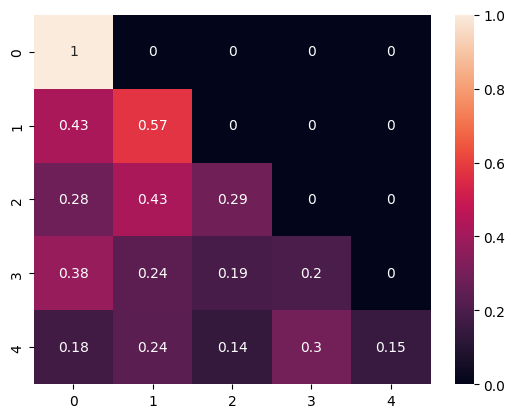

In [52]:
masked_softmax = softmax(M)
sns.heatmap(masked_softmax, annot=True)

In [53]:
def multihead_attention(Q, K, V, d_key, masked=False):
    omega = Q @ K.transpose(-2, -1)/ math.sqrt(d_key)
    if masked:
        omega = omega.masked_fill(torch.tril(omega) == 0, float("-inf"))
    return multihead_softmax(omega) @ V

### Masked Softmax

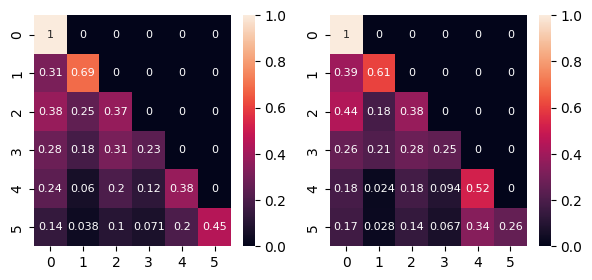

In [54]:
omega = Q @ K.transpose(-2, -1)  / math.sqrt(d_key)
omega = omega.masked_fill(torch.tril(omega) == 0, float("-inf"))
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.heatmap(multihead_softmax(omega)[0].detach().numpy(), annot=True, ax=ax[0], annot_kws={"size": 8})
sns.heatmap(multihead_softmax(omega)[1].detach().numpy(), annot=True, ax=ax[1], annot_kws={"size": 8})
fig.show()

* Now only previous words/affinity will give context to the current tokens

In [55]:
masked_attn_out = multihead_attention(Q, K, V, d_key, masked=True)

masked_attn_out.shape

torch.Size([3, 6, 100])

## Self Attention Vs Cross Attention

* Attention supports both masked and non-masked multihead attention as it provides the fecility to Self-Attention & Cross-Attention.
* When Query, Key and Value all are from **Same Source** then It is called Self-Attention.
* Where Query is from **One Source** and Key, Value are from **Another Source** then it is called Cross-Attention.

## Add & Norm (Convergence Optimizations)

![Add & Norm](images/Arch_Add&Norm.png)

### Skip Connections (Add)

* In skip connections a copy of input is added with the output of the set of calculations.
* In this particular example input embeddings are added with the results of Multi-Head Attention.


```sh

                  Input (X)
                   |
                   |
                   o Fork
                   | \
          |        |   \               A
          |        |     \             |
          |        |       |           |
          |        |   |-----------|   |
          |        |   |  Multi    |   |   Backward
Forward   |        |   |    |      |   |  
          |        |   |  Head     |   |
          |        |   |    |      |   |
          V        |   | Attention |
                   |   |-----------|
                   |       |
                   |      /
                   |    /
                   |  /
                  addition
                   |
                   |
                  Output (X)

```

* Because of skip connection the gradients can travel faster to initial layers and initial layers can learn as fast as final layers, This helps when we are building very Deep Neural Networks

In [56]:
X.shape, masked_attn_out.shape

(torch.Size([3, 6, 100]), torch.Size([3, 6, 100]))

In [57]:
add_x = X + masked_attn_out
add_x.shape

torch.Size([3, 6, 100])

### Layer Normalization


\begin{align*}
y_i &= \frac{x_i - \mu}{\sqrt{ \sigma^2 - \epsilon}}. \gamma + \beta \\\\
\text{where } \\
\mu &= \text{mean} \\ 
\sigma^2 &= \text{variance} \\
\epsilon &= \text{constant for numerical stability} \\
\gamma &= \text{learnable parameter for rescale, initialized with 1} = \frac{\delta L}{\delta \gamma} \\
\beta &= \text{learnable parameter for reshift, initialized with 0} = \frac{\delta L}{\delta \beta}
\end{align*}

* This is row-wise normalization, which is different from batch normalization, which makes it independent from batch size.
* Normalization makes it better for convergence, and better generalization.
* Consider all tokens/rows with different different distribution with same distribution type, It would be optimum to converege if we all the tokens dimensions are normalized.

In [58]:
layer_norm = torch.nn.LayerNorm(add_x.shape[-1])

In [59]:
norm_out = layer_norm(add_x)
norm_out.shape

torch.Size([3, 6, 100])

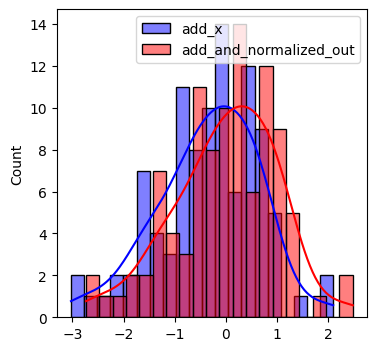

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# fade bars
sns.histplot(add_x[0, 0, :].detach().numpy(), bins=20, ax=ax, kde=True, color='blue', label='add_x' )
sns.histplot(norm_out[0, 0, :].detach().numpy(), bins=20, ax=ax, kde=True, color='red', label='add_and_normalized_out')
ax.legend()
fig.show();

This shows before and after the normalization distribution is slightly moved towards 0.

## Position-Wise Feed Forward Network

![Arch FFN](./images/Arch_FFN.png)

- After Attention block each token from each head is connected separately to a fully connected feed forward network
- As attention block helps the network understand the importance(Attention) of each word in given context. We still need a mechanism to put it to good use.
- Position-Wise Feed Forward Network helps by using the learned importance to localize in a network to build better semantic relationships using word importance.
- According to the paper it is two dense layers with ReLU Activation function.


\begin{align*}
    FFN(x) &= max(0, W_1 X + k^T_1). W_2 + b_2
\end{align*}

In [61]:
X = torch.nn.Linear(d_model, 3 * d_model, bias=True)(X)
X = torch.nn.ReLU()(X)
X = torch.nn.Linear(3 * d_model, d_model, bias=True)(X)

## Repeated Block

*  [ Masked Multihead Attention + Attention + FFN ] is considered a block and this block does two things (Reiterating).
    * Learn importance of each token for given context (Contextual Aggregation)
    * Learn semantic relationship of each token independently with relation to other tokens
* This Block is repeated N number of times to get more refined understanding.
* Pytorch provides a method `ModuleList` to integrate modules given in a list (iterable).

In [62]:
class DummyRepeatBlock(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.linear = torch.nn.Linear(10, 10, bias=True)
    
    def forward(self, X):
        X = self.linear(X)
        return X

repeat_block = torch.nn.ModuleList([DummyRepeatBlock() for i in range(6)])
repeat_block

ModuleList(
  (0-5): 6 x DummyRepeatBlock(
    (linear): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [63]:
for params in repeat_block.parameters():
    print(params.shape)

torch.Size([10, 10])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])


As I am repeating the block 6 times, It is visible that the learnable parameters are multiplied by 6.

## Final Linear Layer and Softmax

* As transformer is `Document Completion`, `Next Word Prediction`, `Autoregressive` Model, we need a final layer that in essence provides us with next word probability.
* The last tokens dimentions (T = -1) probabilities(tensorflow)/logits(pytorch) will be selected to interpret next token.